In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [42]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [43]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [44]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [45]:
df[df['txt_content'].str.len() == 7]

,jpg_file,txt_content
6342,006343.jpg,Y4JS1VW
6741,006742.jpg,3TB9QOO
7180,007181.jpg,AMSML13


In [46]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [47]:
vocab = np.unique(list(df['txt_content'].sum()))
vocab = list(vocab)
vocab.append("*")
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*'],
      dtype='<U1')

In [48]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (50, 180)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    num_parts = 7

    # Create a blank white image
    image = np.ones((*size, 1), dtype=np.uint8) * 255  # White background

    # Calculate positions for each part
    part_width = size[1] / num_parts
    vertical_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    vertical_positions = vertical_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_y = int((size[0] + cv2.getTextSize(text, font, font_scale, font_thickness)[0][1]) / 2)

    # Draw each letter at the calculated position
    for char, x in zip(text, vertical_positions):
        char_size, _ = cv2.getTextSize(char, font, font_scale, font_thickness)
        char_x = x - char_size[0] // 2  # Center the character horizontally within its part
        cv2.putText(image, char, (char_x, text_y), font, font_scale, (0,), font_thickness, lineType=cv2.LINE_AA)
    return image

In [49]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [50]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.

  
  return X,Y,df['txt_content']

X_train, Y_train,labels_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val,labels_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

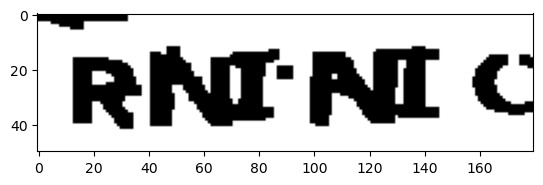

In [51]:
plt.imshow(X_train[0], cmap='gray')

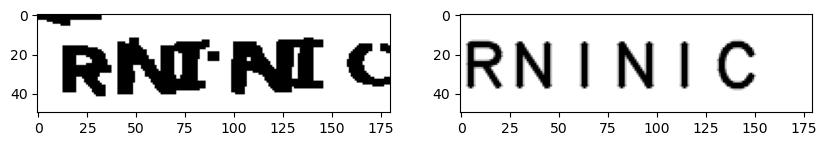

In [52]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [53]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [54]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_3.tf',custom_objects={"rmse": rmse,"psnr":psnr})

In [55]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

32/32 [==============================] - 2s 45ms/step


In [58]:
Y_val_pred[:2].shape.shape[2]

AttributeError: 'tuple' object has no attribute 'shape'

In [68]:
from sklearn.preprocessing import OneHotEncoder

def get_x_y_classification(X_pred, labels):
    # Adjust labels if their length is not equal to 7
    labels = labels.apply(lambda x: x + '*' if len(x) != 7 else x)

    # Define bins
    num_parts = 7
    img_width = 180
    bins = np.arange(0,180,180//7)

    # Initialize lists to hold the split images and one-hot encoded labels
    x = []
    y = []

    # One-hot encoder for labels
    encoder = OneHotEncoder()

    # Fit the encoder on the labels (unique characters)
    unique_chars = set(''.join(labels))
    encoder.fit(np.array(list(unique_chars)).reshape(-1, 1))

    # Process each image and corresponding label
    for img, label in zip(X_pred, labels):
        # Split the image into 7 parts
        for i in range(num_parts):
            start, end = bins[i], bins[i + 1]
            part_img = img[:, start:end,:]
            x.append(part_img)

            # One-hot encode the corresponding character
            char = label[i]
            one_hot = encoder.transform([[char]])[0]
            y.append(one_hot.toarray())

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    return x, y

X_train,Y_train = get_x_y_classification(Y_train_pred,labels_train)
X_val,Y_val = get_x_y_classification(Y_val_pred,labels_val)

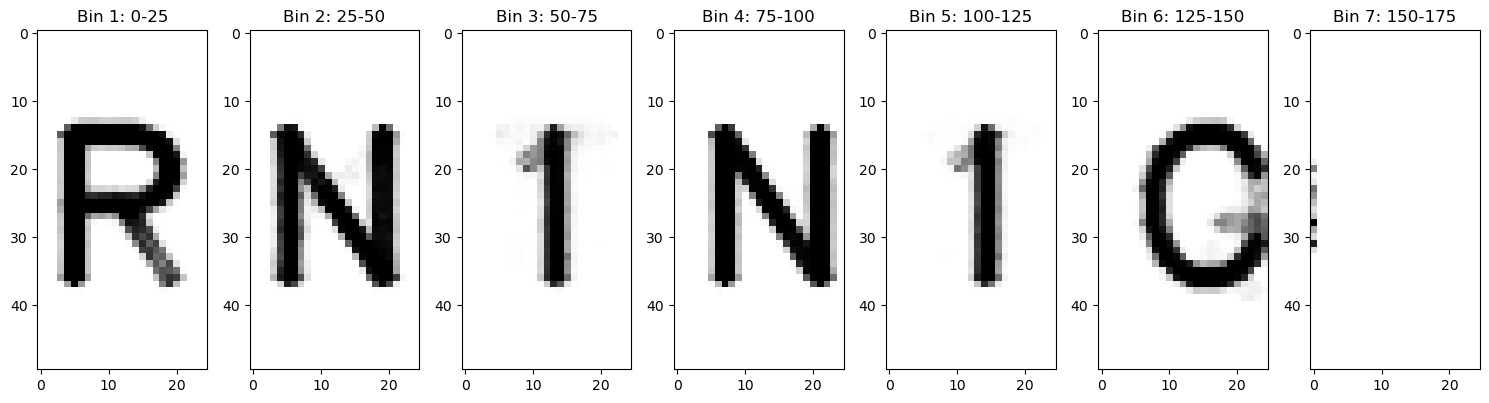

In [66]:
bins = np.arange(0,180,180//7)

# Create subplots
num_bins = len(bins) - 1
fig, axes = plt.subplots(1, num_bins, figsize=(15, 5))

# Plot each bin separately
for i in range(num_bins):
    bin_start = bins[i]
    bin_end = bins[i + 1]
    bin_slice = Y_train_pred[0,:,bin_start:bin_end]
    axes[i].imshow(bin_slice, cmap='gray')
    axes[i].set_title(f'Bin {i+1}: {bin_start}-{bin_end}')
plt.tight_layout()
plt.show()

In [18]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

In [19]:
def conv_bn_relu(filters, kernel_size, strides=(1, 1), padding='same'):
    def layer(x):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x
    return layer

def crop(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return x2_cropped

In [69]:
def classifier(input_img, num_blocks=1, num_downsample=3,n_out = 38):
    x = input_img

    for _ in range(2):
        x = conv_bn_relu(64, (3, 3))(x)

    # Contracting path
    for _ in range(num_downsample):
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_out, activation='softmax')(x)

    return tf.keras.Model(inputs=input_img, outputs=output)


input_shape = X_train.shape[1:]  # Example input shape
input_img = Input(shape=input_shape)
model = classifier(input_img, num_blocks=3, num_downsample=4)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 25, 1)]       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 50, 25, 64)        640       
                                                                 
 batch_normalization_51 (Ba  (None, 50, 25, 64)        256       
 tchNormalization)                                               
                                                                 
 re_lu_51 (ReLU)             (None, 50, 25, 64)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 50, 25, 64)        36928     
                                                                 
 batch_normalization_52 (Ba  (None, 50, 25, 64)        256       
 tchNormalization)                                         

In [ ]:
keras.utils.plot_model(model, to_file="here.png", show_shapes=True)

In [ ]:
checkpoint = ModelCheckpoint(
    'classifier_aug_best.tf',
    monitor='val_rmse',  # Use 'val_loss' as an approximation of RMSE if the metric isn't directly available
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
history = model.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=150,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/150


2024-07-19 16:38:30.485616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-19 16:38:31.859150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-19 16:38:32.579140: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x798804d082c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-19 16:38:32.579168: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-19 16:38:32.583315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-19 16:38:32.697820: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

In [70]:
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)

219/219 [==============================] - 1s 3ms/step


In [71]:
def one_hot_to_class_indices(one_hot_labels):
    return np.argmax(one_hot_labels, axis=-1)

In [74]:
from sklearn.metrics import accuracy_score,classification_report

# Convert one-hot encoded labels to class indices for true labels
Y_val_class_indices = np.argmax(Y_val, axis=-1)

# Convert predictions to class indices
Y_val_pred_class_indices = np.argmax(Y_val_pred, axis=-1)

# Compute accuracy
accuracy = accuracy_score(Y_val_class_indices, Y_val_pred_class_indices)
print(f'Classification Accuracy: {accuracy}')

Classification Accuracy: 0.023428571428571427


In [90]:
report = classification_report(Y_val_class_indices, Y_val_pred_class_indices, output_dict=True, zero_division=0)
for label, metrics in report.items():
    if label.isdecimal():
        print(f'Class {vocab[int(label)]}:')
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-score: {metrics['f1-score']:.2f}")
        print(f"  Support: {metrics['support']:.2f}\n")
    else:
        print(label,metrics)


Class 0:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 999.00

Class 1:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 184.00

Class 2:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 198.00

Class 3:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 162.00

Class 4:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 138.00

Class 5:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 153.00

Class 6:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 161.00

Class 7:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 175.00

Class 8:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 189.00

Class 9:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 147.00

Class ?:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 150.00

Class A:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 150.00

Class B:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Sup

In [ ]:
model.save('classifier_aug_best.keras')